## Building a Simple Decision Tree

In this tutorial we'll build a machine learning model that classifies molecules as soluble or insoluble.  After building the model, we'll visualize the results.  

### Software Installation
One of the Python libraries [dtreeviz](https://github.com/parrt/dtreeviz) that we are going to install requires the installation of a program called [graphviz](https://graphviz.org/).  We can use [apt-get](https://help.ubuntu.com/community/AptGet/Howto) to install graphviz.

In [71]:
!apt-get install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


Install the necessary Python libraries

In [72]:
#!pip install dtreeviz rdkit-pypi PyTDC scikit-learn

# Added pandas & changed rdkit-pypi to rdkit
!pip install dtreeviz rdkit PyTDC scikit-learn pandas

### Setup
Import the necessary Python libraries

In [7]:
import pandas as pd #data table manipulation
from rdkit import Chem # basic cheminformatics
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors
import math #needed for log10
import seaborn as sns #plotting
from sklearn.tree import DecisionTreeClassifier, plot_tree # decision trees
from sklearn.model_selection import train_test_split # split a dataset
from tqdm.auto import tqdm # progress bar
from matplotlib import pyplot as plt # plotting
# original dtreeviz import (commented out to test updated code)
#from dtreeviz.trees import * #plotting decision trees
# updated code from dtreeviz repo - https://github.com/parrt/dtreeviz
import dtreeviz
# original scikit_learn metrics import (commented out to test updated code)
#from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score, plot_roc_curve, plot_confusion_matrix # model stats
# Deprecations of plot_roc_curve & plot_confusion_matrix from scikit-learn version 1.2 - updated code below
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score, RocCurveDisplay, ConfusionMatrixDisplay # model stats
from tdc.single_pred import ADME
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.rdBase import BlockLogs

We want to have progress bars for operations we perfrom on the Pandas dataframe.  In order to do this we neeed to use the function [tqdm.pandas](https://datascientyst.com/progress-bars-pandas-python-tqdm/).

In [8]:
tqdm.pandas()

A simple function to calculate molecular weight, LogP, number of aromatic rings, number of hydrogen bond donors and acceptors from a SMILES

In [9]:
def calc_descriptors(mol):
    if mol:
        Chem.DeleteSubstructs(mol, Chem.MolFromSmarts("[#1X0]"))
        mw, logp, num_arom_rings, hbd, hba = [x(mol) for x in [MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors]]
        res = [mw, logp, num_arom_rings, hbd, hba]
    else:
        res = [None] * 5
    return res

The molecules in this dataset have a number of salts and other functionality that can create issues with descriptor calcuations.  In order to avoid some of these problems we can use the function below to standardize the molecules.

In [10]:
def standardize(smiles):
    # Code borrowed from https://bitsilla.com/blog/2021/06/standardizing-a-molecule-using-rdkit/
    # follows the steps in
    # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
    # as described **excellently** (by Greg) in
    # https://www.youtube.com/watch?v=eWTApNX8dJQ
    mol = Chem.MolFromSmiles(smiles)

    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol)

    # if many fragments, get the "parent" (the actual mol we are interested in)
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)

    # note that no attempt is made at reionization at this step
    # nor at ionization at some pH (rdkit has no pKa caculator)
    # the main aim to to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogue, etc.

    te = rdMolStandardize.TautomerEnumerator() # idem
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)

    return taut_uncharged_parent_clean_mol

### Reading the Input Data
Read data from ["ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure"](https://pubs.acs.org/doi/10.1021/ci034243x) as supplied by [Therapeutic Data Commons](https://tdcommons.ai/)

In [11]:
data = ADME(name = 'Solubility_AqSolDB')
sol_df = data.get_data()

Found local copy...
Loading...
Done!


Let's take a look at the input data, which has three columns
- Drug_ID - the molecule name
- Drug - the SMILES
- Y - the log of the aqueous solubility in uM

In [12]:
sol_df

,Drug_ID,Drug,Y
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065
...,...,...,...
9977,tetracaine,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.010000
9978,tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,-2.930000
9979,thymol,Cc1ccc(C(C)C)c(O)c1,-2.190000
9980,verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,-3.980000


I don't like the names of the columns, let's rename them.

In [13]:
sol_df.columns = ["Name","SMILES","LogS"]
sol_df

,Name,SMILES,LogS
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065
...,...,...,...
9977,tetracaine,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.010000
9978,tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,-2.930000
9979,thymol,Cc1ccc(C(C)C)c(O)c1,-2.190000
9980,verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,-3.980000


Now let's reorder the columns.

In [14]:
sol_df = sol_df[['SMILES','Name','LogS']]
sol_df

,SMILES,Name,LogS
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],"N,N,N-trimethyloctadecan-1-aminium bromide",-3.616127
1,O=C1Nc2cccc3cccc1c23,Benzo[cd]indol-2(1H)-one,-3.254767
2,O=Cc1ccc(Cl)cc1,4-chlorobenzaldehyde,-2.177078
3,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",-3.924409
4,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,-4.662065
...,...,...,...
9977,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,tetracaine,-3.010000
9978,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,tetracycline,-2.930000
9979,Cc1ccc(C(C)C)c(O)c1,thymol,-2.190000
9980,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,verapamil,-3.980000


In [15]:
# Error message occurred when running molecule standardisation and process was stuck at 39%
# This pointed to molecule at index 3894

# Checked out molecule at index 3894
sol_df.iloc[3894]

SMILES          CN1C=CC=C/C1=C\[NH+]=O.[I-]
Name      pralidoxime iodide [usan:inn:jan]
LogS                                -0.7405
Name: 3894, dtype: object

In [16]:
# Considered replacing the SMILES with the one from ChEMBL database
# https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL14577/

# Replaced old SMILES string from index 3894 with a different SMILES representation from ChEMBL database
sol_df["SMILES"] = sol_df["SMILES"].str.replace("CN1C=CC=C/C1=C\[NH+]=O.[I-]", "C[n+]1ccccc1C=NO.[I-]")

In [17]:
# Confirmed the SMILES has been replaced
sol_df.iloc[3894]

SMILES                C[n+]1ccccc1C=NO.[I-]
Name      pralidoxime iodide [usan:inn:jan]
LogS                                -0.7405
Name: 3894, dtype: object

Before we calculate descriptors, we're going to standardize the molecules. This process removes counterions, neutralizes molecules, and generates a standard tautomer.  This process also generates **a lot** of logging output.  We don't want to look at that output, so we're going to use the function [BlockLogs](https://www.rdkit.org/docs/source/rdkit.rdBase.html) to temporarily turn off logging.  Once we're finished we delete the variable **block** and logging is back on.

In [18]:
block = BlockLogs()
sol_df['mol'] = sol_df.SMILES.progress_apply(standardize)
del block

  0%|          | 0/9982 [00:00<?, ?it/s]

Add a new column "IsSol" to indicate whether a molecule's solubility is greater than 200uM

In [19]:
sol_df['IsSol'] = sol_df.LogS > math.log10(200 * 1e-6)

Plot solubility as a sanity check

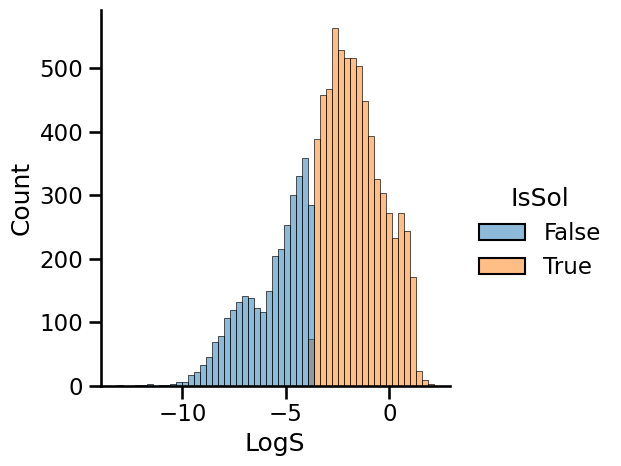

In [20]:
sns.set_context('talk') # Set the fonts the way I like them
sns.displot(x='LogS',hue="IsSol",data=sol_df)

Add the descriptors to the dataframe.  Note that all the descriptors are going into one column called "desc".

In [21]:
sol_df['desc'] = sol_df.mol.progress_apply(calc_descriptors)

  0%|          | 0/9982 [00:00<?, ?it/s]

The function call in the cell above put all the descriptors into a single column called **desc**.  We would like split the descriptors so that each is in its own column.

In [22]:
desc_cols = ['MW','LogP','NumAromatic','HBD','HBA']
sol_df[desc_cols] = sol_df.desc.to_list()

We no longer need the "desc" column, let's get rid of it.

In [23]:
sol_df.drop("desc",axis=1,inplace=True)

Let's check the dataframe to make sure it's ok.

In [24]:
sol_df

,SMILES,Name,LogS,mol,IsSol,MW,LogP,NumAromatic,HBD,HBA
0,CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],"N,N,N-trimethyloctadecan-1-aminium bromide",-3.616127,<rdkit.Chem.rdchem.Mol object at 0x285b7cc80>,True,312.606,6.95410,0.0,0.0,0.0
1,O=C1Nc2cccc3cccc1c23,Benzo[cd]indol-2(1H)-one,-3.254767,<rdkit.Chem.rdchem.Mol object at 0x285b7c120>,True,169.183,2.40550,2.0,1.0,1.0
2,O=Cc1ccc(Cl)cc1,4-chlorobenzaldehyde,-2.177078,<rdkit.Chem.rdchem.Mol object at 0x285b7d070>,True,140.569,2.15250,1.0,0.0,1.0
3,CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",-3.924409,<rdkit.Chem.rdchem.Mol object at 0x285b7c890>,False,346.426,5.39400,3.0,2.0,2.0
4,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,-4.662065,<rdkit.Chem.rdchem.Mol object at 0x285b7c510>,False,422.525,2.48540,2.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...
9977,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,tetracaine,-3.010000,<rdkit.Chem.rdchem.Mol object at 0x295ec3d80>,True,264.369,2.61700,1.0,1.0,4.0
9978,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,tetracycline,-2.930000,<rdkit.Chem.rdchem.Mol object at 0x295ec3df0>,True,444.440,-1.46800,1.0,4.0,9.0
9979,Cc1ccc(C(C)C)c(O)c1,thymol,-2.190000,<rdkit.Chem.rdchem.Mol object at 0x295ec3e60>,True,150.221,2.82402,1.0,1.0,1.0
9980,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,verapamil,-3.980000,<rdkit.Chem.rdchem.Mol object at 0x295ec3ed0>,False,454.611,5.09308,2.0,0.0,6.0


In order to build a machine learning model, we will split the data into training and test sets. By default, the function train_test_split from scikit_learn puts 80% of the data into the training set and 20% into the test set.

In [25]:
train, test = train_test_split(sol_df)

Our data is currently in a Pandas dataframe.  I find it easier to build models with X and y variables. We'll split the training and test sets into X and y variables.

In [26]:
train_X = train[desc_cols]
train_y = train.IsSol
test_X = test[desc_cols]
test_y = test.IsSol

Create and train a classifier

In [27]:
cls = DecisionTreeClassifier(max_depth=2)
cls.fit(train_X,train_y)

DecisionTreeClassifier(max_depth=2)

Predict on the test set

In [28]:
pred = cls.predict(test_X)
auc, mcc, kappa = roc_auc_score(test_y, pred),matthews_corrcoef(test_y,pred),cohen_kappa_score(test_y,pred)
print(f"ROC AUC = {auc:.2f}")
print(f"Matthews Correlation Coefficient = {mcc:.2f}")
print(f"Cohen\'s Kappa = {kappa:.2f}")

ROC AUC = 0.82
Matthews Correlation Coefficient = 0.65
Cohen's Kappa = 0.65


Plot a confusion matrix to show the classifier performance

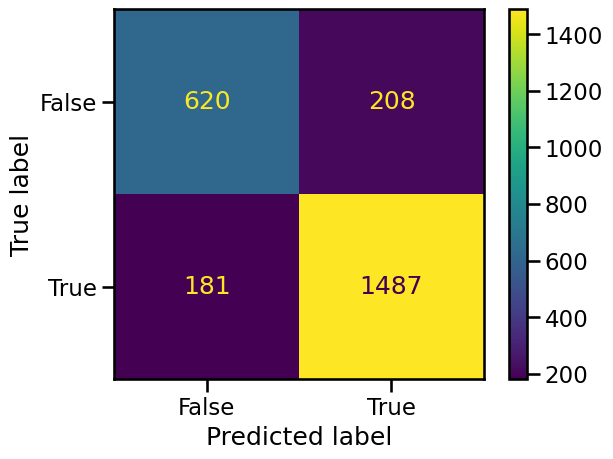

In [29]:
# Original code
#plot_confusion_matrix(cls,test_X,test_y)

# Updated code for scikit_learn version 1.2 onwards
ConfusionMatrixDisplay.from_estimator(cls, test_X, test_y)

Plot an ROC cure to show the classifier performance

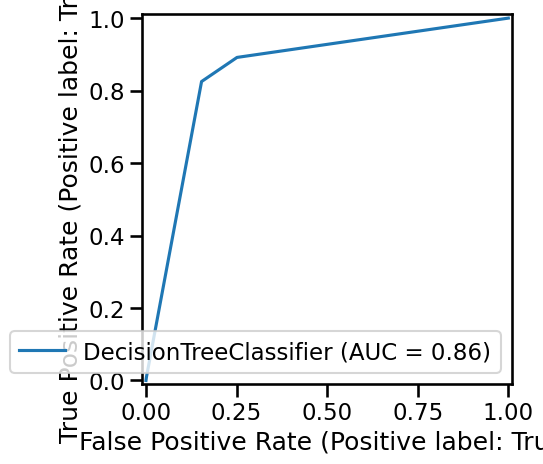

In [30]:
# Original code
#plot_roc_curve(cls,test_X,test_y)

# Updated code for scikit_learn version 1.2 onwards
RocCurveDisplay.from_estimator(cls, test_X, test_y)

Use the default view from SciKit Learn to plot the decision tree

[Text(0.5, 0.8333333333333334, 'LogP <= 3.116\ngini = 0.44\nsamples = 7486\nvalue = [2441, 5045]'),
 Text(0.25, 0.5, 'LogP <= 2.669\ngini = 0.226\nsamples = 5179\nvalue = [673, 4506]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.176\nsamples = 4605\nvalue = [448, 4157]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.477\nsamples = 574\nvalue = [225, 349]'),
 Text(0.75, 0.5, 'HBA <= 13.5\ngini = 0.358\nsamples = 2307\nvalue = [1768, 539]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.338\nsamples = 2250\nvalue = [1765.0, 485.0]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.1\nsamples = 57\nvalue = [3, 54]')]

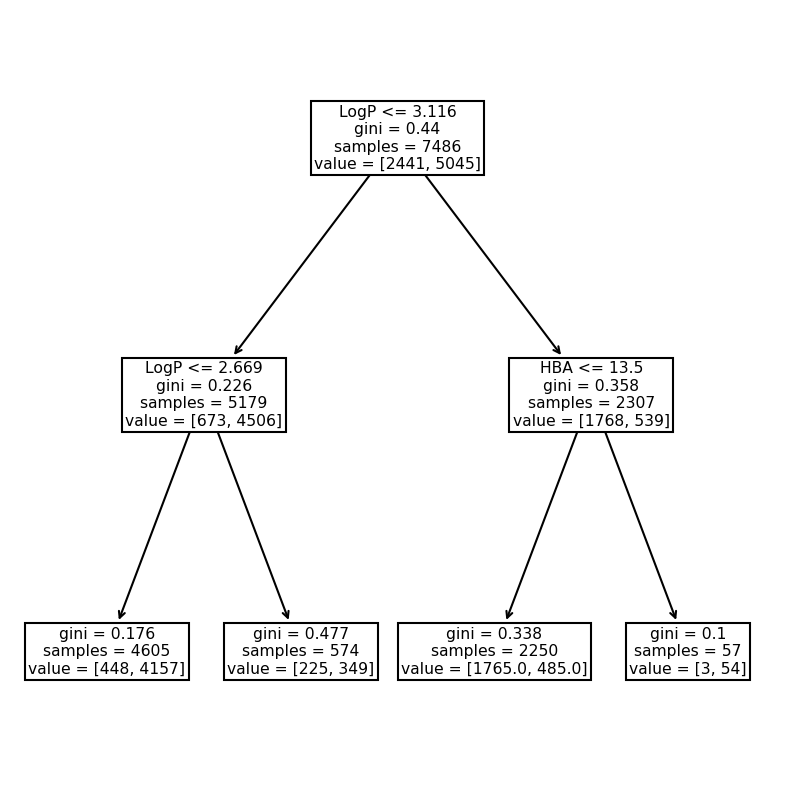

In [31]:
plt.rcParams["figure.figsize"] = (10,10)
plot_tree(cls,feature_names=desc_cols)

Use dtreeviz to plot the decision tree

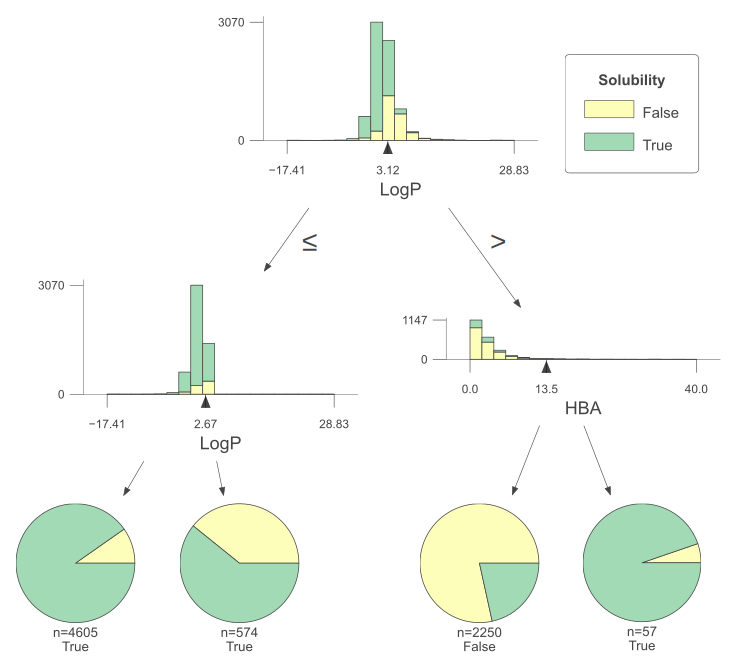

In [32]:
# Original code
# viz = dtreeviz(cls, train_X, train_y, feature_names = desc_cols,
#                target_name = "Solubility",class_names=["False","True"],scale=2)
# viz

# Updated dtreeviz code
viz = dtreeviz.model(cls, train_X, train_y, feature_names = desc_cols,
                     target_name = "Solubility",class_names=["False","True"])
viz.view(scale = 2)

As a final check we're going to see if we can fit a model to incorrect data.  If we shuffle the y values, we shouldn't be able to get a good model.

Shuffle the y-variable as a sanity check

In [33]:
sol_df['fake'] = sol_df.IsSol.sample(frac=1)

Split the dataframe into training a test sets.

In [34]:
fake_train, fake_test = train_test_split(sol_df)

Split the training and test sets into X and y variables

In [35]:
fake_train_X = fake_train[desc_cols]
fake_train_y = fake_train.fake
fake_test_X = fake_test[desc_cols]
fake_test_y = fake_test.fake

Build a classifer

In [36]:
fake_cls = DecisionTreeClassifier(max_depth=2)
fake_cls.fit(fake_train_X,fake_train_y)

DecisionTreeClassifier(max_depth=2)

Generate the predictions

In [37]:
fake_pred = fake_cls.predict(fake_test_X)

Calculate the AUC score

In [38]:
roc_auc_score(fake_test_y,pred)

0.5042413673834092